# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/gdrive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:17<00:00, 2539.80it/s]


In [24]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [0]:
final["preprocessed_reviews"] = preprocessed_reviews

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,title chicken soup riceauthor maurice sendakre...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [0]:
final=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator"],axis=1)

In [0]:
final_last=final.drop(["HelpfulnessDenominator","Time","Summary","Text"],axis=1)

In [30]:
final_last.head()

,Score,preprocessed_reviews
138702,1,book purchased birthday gift year old boy sque...
138707,1,daughter loves really rosie books introduced r...
138708,0,one best children books ever written mini vers...
138692,1,title chicken soup riceauthor maurice sendakre...
138689,1,fun way children learn months year learn poems...


In [0]:
X = final_last["preprocessed_reviews"]

Y = final_last["Score"]

In [0]:
from sklearn.model_selection import train_test_split

x_train ,x_test ,y_train ,y_test = train_test_split(X[:100000], Y[:100000] , test_size = 0.33)

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.2] Bi-Grams and n-Grams.

In [33]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bow = CountVectorizer(ngram_range=(1,2), min_df=10)
x_train_bigram_counts = count_vect_bow.fit_transform(x_train)
x_test_bigram_counts = count_vect_bow.transform(x_test)

print("After Vectorizations")
print("the type of count vectorizer ",type(x_train_bigram_counts))
print("the shape of out train text BOW vectorizer ",x_train_bigram_counts.get_shape())
print("the shape of test text BOW vectorizer ",x_test_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_bigram_counts.get_shape()[1])

After Vectorizations
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out train text BOW vectorizer  (67000, 37588)
the shape of test text BOW vectorizer  (33000, 37588)
the number of unique words including both unigrams and bigrams  37588


## [4.3] TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

x_train_tf_idf = tf_idf_vect.transform(x_train)
x_test_tf_idf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(x_train_tf_idf))
print("the shape of train text TFIDF vectorizer ",x_train_tf_idf.get_shape())
print("the shape of test text TFIDF vectorizer ",x_test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aback', 'abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train text TFIDF vectorizer  (67000, 37588)
the shape of test text TFIDF vectorizer  (33000, 37588)
the number of unique words including both unigrams and bigrams  37588


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

In [36]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))
    


[('terrific', 0.8382848501205444), ('excellent', 0.8220228552818298), ('good', 0.8209983706474304), ('fantastic', 0.7970781326293945), ('wonderful', 0.7886953949928284), ('awesome', 0.7838480472564697), ('perfect', 0.7832510471343994), ('fabulous', 0.7158156633377075), ('amazing', 0.6862372756004333), ('outstanding', 0.6740298271179199)]
[('greatest', 0.7743209004402161), ('nastiest', 0.7294610142707825), ('best', 0.724933922290802), ('disgusting', 0.6997890472412109), ('awful', 0.664620041847229), ('terrible', 0.6551202535629272), ('horrible', 0.6211053133010864), ('worse', 0.6038607358932495), ('gross', 0.5995112657546997), ('spoiled', 0.5834645628929138)]


In [37]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  15669
sample words  ['salmon', 'great', 'taste', 'little', 'sodium', 'regular', 'cans', 'definetly', 'buy', 'product', 'three', 'cats', 'enthusiastic', 'pounce', 'cat', 'treats', 'expected', 'equally', 'greenies', 'not', 'tried', 'left', 'long', 'haired', 'orange', 'male', 'throw', 'hair', 'throws', 'grooming', 'fur', 'much', 'necessarily', 'attribute', 'vomiting', 'search', 'menadione', 'bisulfite', 'msb', 'another', 'reviewer', 'suggested', 'find', 'poison', 'pure', 'form', 'skin', 'mucous', 'membranes', 'study']


In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_train: # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec_train = w2v_model_train.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(67000, 50)
[ 0.71775998 -0.01468137 -0.54331203 -0.69023989 -0.34396104 -0.31110257
 -0.33055907  0.46280262 -0.27561397  0.42561388 -0.42535561  0.26936783
  0.05223912  0.10049348  1.15952297  0.50391733 -0.27032089  0.20127459
  0.41904475 -0.7114821  -0.77804015  0.05659202  0.52344922 -0.14652132
  0.86066161  0.16383566 -0.06457094 -0.27627952 -0.06597427 -1.0887112
 -0.36222858  1.34071232 -0.30162516  0.06360493  0.41569727  0.63200573
 -0.59110687  1.14772366 -0.43947267 -0.41835652 -1.30426045  0.42582719
 -0.01546379  0.32865632  1.39643406 -0.0710756  -0.05595803 -0.00775961
  0.33740323 -0.17731312]


In [0]:
i=0
list_of_sentance_test = []
for sentence in x_test :
    list_of_sentance_test.append(sentence.split())

In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

(33000, 50)
[ 0.3011438   0.42365258 -0.21039304 -0.52521377  0.21147624  0.1634588
  0.00970221 -0.18922431  0.13048732 -0.1839289  -0.40745936  0.30445674
 -0.06222399  0.20566601  0.11024997  0.14071542 -0.08544491  0.42488938
  0.31908942 -0.27178525 -0.1210286  -0.24869324 -0.32326847 -0.38976847
  0.58505529  0.22134797 -0.2099666  -0.58346589  0.550437   -0.01254574
 -0.21908738  0.3662905  -0.17303194  0.36259447 -0.31982572  0.19570929
 -0.10430669 -0.10313621 -0.18664803  0.57231639  0.12242087 -0.04104144
 -0.04605108  0.03903568  0.20140341 -0.67419043  0.08269067 -0.52349731
  0.28963776  0.06217289]


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(x_train)
tf_idf_matrix_test = model.transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

w2v_tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    w2v_tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
#test data

w2v_tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    w2v_tfidf_sent_vectors_test.append(sent_vec)
    row += 1

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
# Please write all the code with proper documentation

parameters = {'alpha' : [0.0001 ,0.001 ,0.01 ,0.1 ,1, 10 ,100 ,1000 ,10000],
             'penalty':['l1','l2']}

sgd_model = SGDClassifier(loss = 'hinge' ,class_weight = 'balanced')

sgd_model_bow = GridSearchCV(sgd_model , param_grid=parameters , cv = 5 ,scoring = 'roc_auc')

sgd_model_bow.fit(x_train_bigram_counts ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [48]:
print("best estimator is :" ,sgd_model_bow.best_estimator_.alpha)
best_alpha = sgd_model_bow.best_estimator_.alpha

best estimator is : 0.001


In [49]:
from sklearn.calibration import CalibratedClassifierCV

sgd_bow = SGDClassifier(loss = 'hinge' ,alpha = best_alpha ,class_weight = 'balanced')
calibrated_bow = CalibratedClassifierCV(sgd_bow , cv = 5 )

calibrated_bow.fit(x_train_bigram_counts ,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

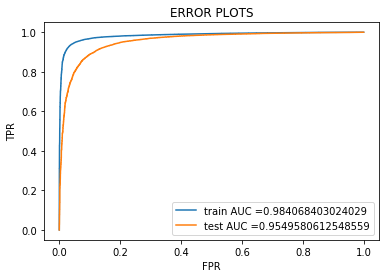

Train confusion matrix
[[ 7595  2346]
 [  982 56077]]
Test confusion matrix
[[ 3069  1766]
 [  636 27529]]


In [50]:
train_fpr_cal_bow, train_tpr_cal_bow, thresholds_cal_bow = roc_curve(y_train, calibrated_bow.predict_proba(x_train_bigram_counts)[:,1])
test_fpr_cal_bow, test_tpr_cal_bow, thresholds_cal_bow = roc_curve(y_test, calibrated_bow.predict_proba(x_test_bigram_counts)[:,1])

plt.plot(train_fpr_cal_bow, train_tpr_cal_bow, label="train AUC ="+str(auc(train_fpr_cal_bow, train_tpr_cal_bow)))
plt.plot(test_fpr_cal_bow, test_tpr_cal_bow, label="test AUC ="+str(auc(test_fpr_cal_bow, test_tpr_cal_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, calibrated_bow.predict(x_train_bigram_counts)))
print("Test confusion matrix")
print(confusion_matrix(y_test, calibrated_bow.predict(x_test_bigram_counts)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

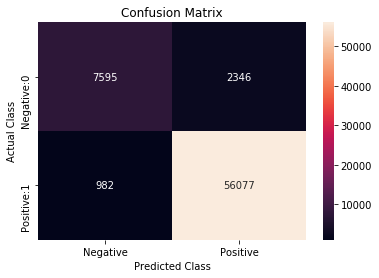

In [51]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_cal_bow = confusion_matrix(y_train, calibrated_bow.predict(x_train_bigram_counts))

df_cm=pd.DataFrame(confusion_matrix_train_cal_bow,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

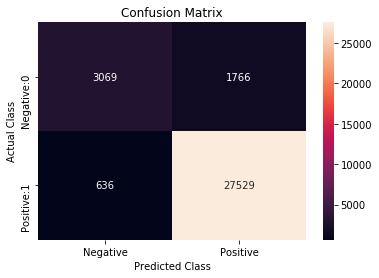

In [52]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_cal_bow = confusion_matrix(y_test, calibrated_bow.predict(x_test_bigram_counts))

df_cm=pd.DataFrame(confusion_matrix_test_cal_bow,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

## Feature importance on BOW with linear SVM

In [0]:
sgd_bow.fit(x_train_bigram_counts ,y_train)

#lets find out top 10 positive features and top 10 negative features.

coefficients_features = pd.DataFrame({"Feature":count_vect_bow.get_feature_names(),"Coefficients":np.transpose(sgd_bow.coef_[0])})

coefficients_features=coefficients_features.sort_values('Coefficients',ascending=False)

In [62]:
print("Top 10 positive features are:\n")
coefficients_features[:10]

Top 10 positive features are:



,Feature,Coefficients
21969,not disappointed,0.879614
18930,loves,0.821887
7852,delicious,0.732569
1887,awesome,0.714739
24879,pleased,0.703773
976,amazing,0.672049
10197,excellent,0.641969
2672,best,0.635999
36876,wonderful,0.633887
14249,great,0.601922


In [63]:
print("Top 10 negative features are:\n")
coefficients_features[-10:]

Top 10 negative features are:



,Feature,Coefficients
32468,tasteless,-0.679142
34983,unfortunately,-0.701324
22332,not recommend,-0.721832
33166,terrible,-0.745996
1899,awful,-0.755497
8362,disappointed,-0.820999
22077,not good,-0.835699
8386,disappointing,-0.886005
22537,not worth,-0.907793
37059,worst,-0.947794


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

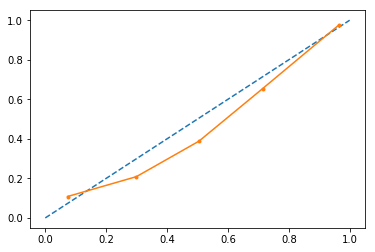

In [64]:
#lets create a reliability diagram for the calibrated probailities

from sklearn.calibration import calibration_curve
from matplotlib import pyplot
probs1 = calibrated_bow.predict_proba(x_test_bigram_counts)[:,1]
#reliability diagram
fop ,mpv = calibration_curve(y_test ,probs1  ,normalize = True)
#plot perfectly calibrated
pyplot.plot([0,1],[0,1] ,linestyle = '--')
#plot calibrated reliability
pyplot.plot(mpv ,fop ,marker = '.')

pyplot.show()

In [65]:
# Please write all the code with proper documentation

parameters = {'alpha' : [0.0001 ,0.001 ,0.01 ,0.1 ,1, 10 ,100 ,1000 ,10000],
             'penalty':['l1','l2']}
sgd_model = SGDClassifier(loss = 'hinge' ,class_weight = 'balanced')

sgd_model_tfidf = GridSearchCV(sgd_model , param_grid=parameters , cv = 5 ,scoring = 'roc_auc')

sgd_model_tfidf.fit(x_train_tf_idf ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [66]:
print("best alpha is :" ,sgd_model_tfidf.best_estimator_.alpha)
print("best penalty is :" ,sgd_model_tfidf.best_estimator_.penalty)
best_alpha = sgd_model_tfidf.best_estimator_.alpha

best alpha is : 0.0001
best penalty is : l2


In [67]:
from sklearn.calibration import CalibratedClassifierCV

sgd_tfidf = SGDClassifier(loss = 'hinge' ,alpha = best_alpha ,penalty = 'l2' ,class_weight = 'balanced')
calibrated_tfidf = CalibratedClassifierCV(sgd_tfidf , cv = 5 )

calibrated_tfidf.fit(x_train_tf_idf ,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

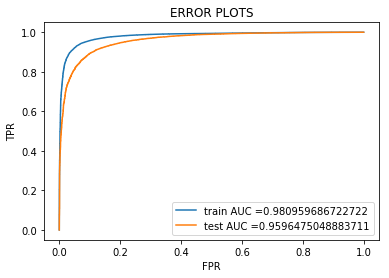

Train confusion matrix
[[ 8228  1713]
 [ 1311 55748]]
Test confusion matrix
[[ 3328  1507]
 [  786 27379]]


In [68]:
train_fpr_cal_tfidf, train_tpr_cal_tfidf, thresholds_cal_tfidf = roc_curve(y_train, calibrated_tfidf.predict_proba(x_train_tf_idf)[:,1])
test_fpr_cal_tfidf, test_tpr_cal_tfidf, thresholds_cal_tfidf = roc_curve(y_test, calibrated_tfidf.predict_proba(x_test_tf_idf)[:,1])

plt.plot(train_fpr_cal_tfidf, train_tpr_cal_tfidf, label="train AUC ="+str(auc(train_fpr_cal_tfidf, train_tpr_cal_tfidf)))
plt.plot(test_fpr_cal_tfidf, test_tpr_cal_tfidf, label="test AUC ="+str(auc(test_fpr_cal_tfidf, test_tpr_cal_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, calibrated_tfidf.predict(x_train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, calibrated_tfidf.predict(x_test_tf_idf)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

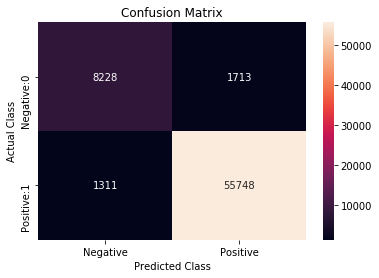

In [69]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_cal_tfidf = confusion_matrix(y_train, calibrated_tfidf.predict(x_train_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_train_cal_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

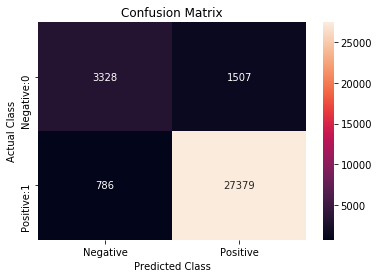

In [70]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_cal_tfidf = confusion_matrix(y_test, calibrated_tfidf.predict(x_test_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_test_cal_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

##  Feature importance on TFIDF with linear SVM

In [0]:
sgd_tfidf.fit(x_train_tf_idf ,y_train)

#lets find out top 10 positive features and top 10 negative features.

coefficients_features = pd.DataFrame({"Feature":tf_idf_vect.get_feature_names(),"Coefficients":np.transpose(sgd_tfidf.coef_[0])})

coefficients_features=coefficients_features.sort_values('Coefficients',ascending=False)

In [73]:
print("Top 10 positive features are:\n")
coefficients_features[:10]

Top 10 positive features are:



,Feature,Coefficients
14249,great,5.956858
2672,best,5.258561
7852,delicious,4.315427
13644,good,4.203853
18930,loves,4.140728
18639,love,3.943352
24434,perfect,3.755179
36876,wonderful,3.335773
10197,excellent,3.250487
21392,nice,2.818407


In [74]:
print("Top 10 negative features are:\n")
coefficients_features[-10:]

Top 10 negative features are:



,Feature,Coefficients
22332,not recommend,-2.694402
33166,terrible,-2.934950
1899,awful,-2.974328
22537,not worth,-2.987294
8386,disappointing,-3.207477
34983,unfortunately,-3.247775
22077,not good,-3.435852
37059,worst,-3.559345
21788,not,-4.102102
8362,disappointed,-4.345610


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [75]:
# Please write all the code with proper documentation

parameters = {'alpha' : [0.0001 ,0.001 ,0.01 ,0.1 ,1, 10 ,100 ,1000 ,10000],
             'penalty':['l1','l2']}
sgd_model = SGDClassifier(loss = 'hinge' ,class_weight = 'balanced')

sgd_model_avgw2v = GridSearchCV(sgd_model , param_grid=parameters , cv = 5 ,scoring = 'roc_auc')

sgd_model_avgw2v.fit(sent_vectors_train ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [76]:
print("best alpha is :" ,sgd_model_avgw2v.best_estimator_.alpha)
print("best penalty is :" ,sgd_model_avgw2v.best_estimator_.penalty)
best_alpha = sgd_model_avgw2v.best_estimator_.alpha

best alpha is : 0.01
best penalty is : l2


In [77]:
from sklearn.calibration import CalibratedClassifierCV

sgd_avgw2v = SGDClassifier(loss = 'hinge' ,alpha = best_alpha ,penalty = 'l2' ,class_weight = 'balanced')
calibrated_avgw2v = CalibratedClassifierCV(sgd_avgw2v , cv = 5 )

calibrated_avgw2v.fit(sent_vectors_train ,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

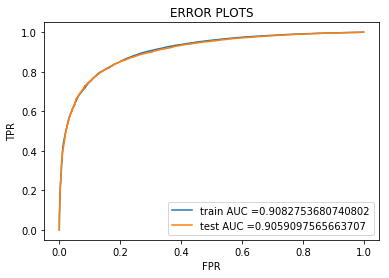

Train confusion matrix
[[ 4537  5404]
 [ 1898 55161]]
Test confusion matrix
[[ 2123  2712]
 [  955 27210]]


In [78]:
train_fpr_cal_avgw2v, train_tpr_cal_avgw2v, thresholds_cal_avgw2v = roc_curve(y_train, calibrated_avgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr_cal_avgw2v, test_tpr_cal_avgw2v, thresholds_cal_avgw2v = roc_curve(y_test, calibrated_avgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_cal_avgw2v, train_tpr_cal_avgw2v, label="train AUC ="+str(auc(train_fpr_cal_avgw2v, train_tpr_cal_avgw2v)))
plt.plot(test_fpr_cal_avgw2v, test_tpr_cal_avgw2v, label="test AUC ="+str(auc(test_fpr_cal_avgw2v, test_tpr_cal_avgw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, calibrated_avgw2v.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, calibrated_avgw2v.predict(sent_vectors_test)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

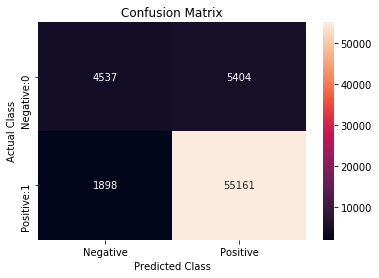

In [79]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_cal_avgw2v = confusion_matrix(y_train, calibrated_avgw2v.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_cal_avgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

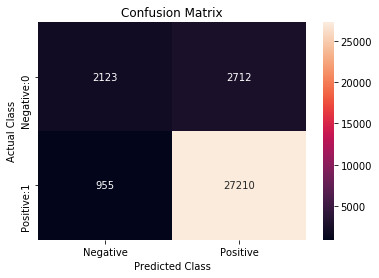

In [80]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_cal_avgw2v = confusion_matrix(y_test, calibrated_avgw2v.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_cal_avgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [81]:
# Please write all the code with proper documentation

sgd_model = SGDClassifier(loss = 'hinge' ,class_weight = 'balanced')

sgd_model_tfidfavgw2v = GridSearchCV(sgd_model , param_grid=parameters , cv = 5 ,scoring = 'roc_auc')

sgd_model_tfidfavgw2v.fit(w2v_tfidf_sent_vectors_train ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [82]:
print("best alpha is :" ,sgd_model_tfidfavgw2v.best_estimator_.alpha)
print("best penalty is :" ,sgd_model_tfidfavgw2v.best_estimator_.penalty)
best_alpha = sgd_model_tfidfavgw2v.best_estimator_.alpha

best alpha is : 0.01
best penalty is : l2


In [83]:
sgd_tfidfavgw2v = SGDClassifier(loss = 'hinge' ,alpha = best_alpha ,penalty = 'l2' ,class_weight = 'balanced')
calibrated_tfidfavgw2v = CalibratedClassifierCV(sgd_tfidfavgw2v , cv = 5 )

calibrated_tfidfavgw2v.fit(w2v_tfidf_sent_vectors_train ,y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

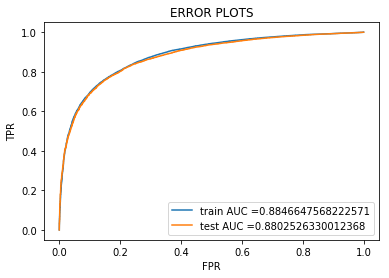

Train confusion matrix
[[ 3542  6399]
 [ 1765 55294]]
Test confusion matrix
[[ 1632  3203]
 [  906 27259]]


In [84]:
train_fpr_cal_tfidfavgw2v, train_tpr_cal_tfidfavgw2v, thresholds_cal_tfidfavgw2v = roc_curve(y_train, calibrated_tfidfavgw2v.predict_proba(w2v_tfidf_sent_vectors_train)[:,1])
test_fpr_cal_tfidfavgw2v, test_tpr_cal_tfidfavgw2v, thresholds_cal_tfidfavgw2v = roc_curve(y_test, calibrated_tfidfavgw2v.predict_proba(w2v_tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_cal_tfidfavgw2v, train_tpr_cal_tfidfavgw2v, label="train AUC ="+str(auc(train_fpr_cal_tfidfavgw2v, train_tpr_cal_tfidfavgw2v)))
plt.plot(test_fpr_cal_tfidfavgw2v, test_tpr_cal_tfidfavgw2v, label="test AUC ="+str(auc(test_fpr_cal_tfidfavgw2v, test_tpr_cal_tfidfavgw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, calibrated_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, calibrated_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_test)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

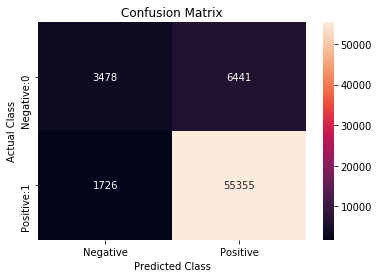

In [70]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_cal_tfidfavgw2v = confusion_matrix(y_train, calibrated_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_cal_tfidfavgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

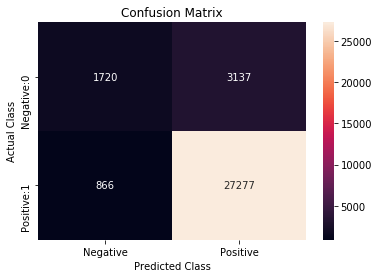

In [71]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_cal_tfidfavgw2v = confusion_matrix(y_test, calibrated_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_cal_tfidfavgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

## [5.2] RBF SVM

In [0]:
from sklearn.model_selection import train_test_split

x_train ,x_test ,y_train ,y_test = train_test_split(X[:20000], Y[:20000] , test_size = 0.20)

In [73]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bow_rbf = CountVectorizer(ngram_range=(1,2), min_df=10 ,max_features=500)
x_train_bigram_counts_rbf = count_vect_bow_rbf.fit_transform(x_train)
x_test_bigram_counts_rbf = count_vect_bow_rbf.transform(x_test)

print("After Vectorizations")
print("the type of count vectorizer ",type(x_train_bigram_counts_rbf))
print("the shape of out train text BOW vectorizer ",x_train_bigram_counts_rbf.get_shape())
print("the shape of test text BOW vectorizer ",x_test_bigram_counts_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_bigram_counts_rbf.get_shape()[1])

After Vectorizations
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out train text BOW vectorizer  (16000, 500)
the shape of test text BOW vectorizer  (4000, 500)
the number of unique words including both unigrams and bigrams  500


In [74]:
tf_idf_vect_rbf = TfidfVectorizer(ngram_range=(1,2), min_df=10 ,max_features = 500)
tf_idf_vect_rbf.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect_rbf.get_feature_names()[0:10])
print('='*50)

x_train_tf_idf_rbf = tf_idf_vect_rbf.transform(x_train)
x_test_tf_idf_rbf = tf_idf_vect_rbf.transform(x_test)
print("the type of count vectorizer ",type(x_train_tf_idf_rbf))
print("the shape of train text TFIDF vectorizer ",x_train_tf_idf_rbf.get_shape())
print("the shape of test text TFIDF vectorizer ",x_test_tf_idf_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_tf_idf_rbf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'already', 'also', 'although']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train text TFIDF vectorizer  (16000, 500)
the shape of test text TFIDF vectorizer  (4000, 500)
the number of unique words including both unigrams and bigrams  500


In [0]:
#word2vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train_rbf=[]
for sentance in x_train:
    list_of_sentance_train_rbf.append(sentance.split())

In [76]:
# min_count = 5 considers only words that occured atleast 10 times
w2v_model_train_rbf=Word2Vec(list_of_sentance_train,min_count=10,size=50, workers=4)
print(w2v_model_train_rbf.wv.most_similar('great'))
print('='*50)
print(w2v_model_train_rbf.wv.most_similar('worst'))

[('terrific', 0.8526521921157837), ('wonderful', 0.8387733101844788), ('awesome', 0.8305999040603638), ('good', 0.8202376365661621), ('excellent', 0.8182376623153687), ('fantastic', 0.8113438487052917), ('perfect', 0.761300802230835), ('amazing', 0.7304612398147583), ('fabulous', 0.6907686591148376), ('nice', 0.6848669052124023)]
[('greatest', 0.7639138698577881), ('best', 0.6748517751693726), ('disgusting', 0.6643232107162476), ('foul', 0.6139352321624756), ('worse', 0.607251763343811), ('horrible', 0.6059979200363159), ('awful', 0.603512704372406), ('tastiest', 0.5925966501235962), ('terrible', 0.5912677049636841), ('closest', 0.5901381373405457)]


In [77]:
w2v_words_train_rbf = list(w2v_model_train_rbf.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train_rbf))
print("sample words ", w2v_words_train_rbf[0:50])

number of words that occured minimum 5 times  10852
sample words  ['prepared', 'package', 'flavorful', 'rice', 'tonight', 'dinner', 'everyone', 'loved', 'used', 'cooker', 'full', 'turned', 'perfect', 'mix', 'water', 'salt', 'tad', 'butter', 'absolutely', 'irresistible', 'not', 'stop', 'finished', 'last', 'grain', 'wait', 'try', 'varieties', 'definitely', 'worth', 'expense', 'much', 'better', 'deal', 'amazon', 'find', 'locally', 'glad', 'macaroni', 'cheese', 'kind', 'adults', 'kids', 'family', 'enjoy', 'slightly', 'sharp', 'cheddar', 'flavor', 'makes']


In [78]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_train_rbf: # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train_rbf:
            vec_train = w2v_model_train_rbf.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train_rbf.append(sent_vec_train)
sent_vectors_train_rbf = np.array(sent_vectors_train_rbf)
print(sent_vectors_train_rbf.shape)
print(sent_vectors_train_rbf[0])

(16000, 50)
[-1.45826476  1.23505315  0.1530947   0.78546935  0.0970534   1.19743477
  0.75447191  0.48921649  0.90226299  1.34509068  0.18444997 -0.1002211
  1.23139297  0.53369415  0.76511467 -0.37964067 -0.84325473  0.97403112
  0.13089564  0.97857952  0.0926754  -0.83536962  0.02802765  0.03781691
  0.33183999  0.34904484 -0.99178751 -0.15378149 -2.07848034 -0.44211517
 -1.27719149  0.67492301 -0.15901929 -0.237002    0.35002225 -0.1166515
 -1.26984852 -0.05325546 -0.47674509  0.42110541  0.10926528 -0.36652379
 -0.90994429 -1.0263184   0.84105968  0.43475367 -0.27036907  0.22063898
  0.32817645  0.0055012 ]


In [79]:
i=0
list_of_sentance_test_rbf = []
for sentence in x_test :
    list_of_sentance_test_rbf.append(sentence.split())
	
	

	
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_test_rbf: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train_rbf:
            vec = w2v_model_train_rbf.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_rbf.append(sent_vec)
sent_vectors_test_rbf = np.array(sent_vectors_test_rbf)
print(sent_vectors_test_rbf.shape)
print(sent_vectors_test_rbf[0])

(4000, 50)
[ 0.10693028  0.27032869 -0.71560208  0.40158712  0.89559134 -0.97789134
 -0.12387243  0.33057487  0.9514599  -0.73624231 -1.09670539  0.52377951
  0.47454336 -0.78920976  1.12376771 -0.28955054 -0.50710274 -0.44480561
 -0.14455277 -0.08735282 -0.15326017  0.73849243  0.84329028 -0.35204952
 -0.10148038  0.69263725  0.59756802  0.15083782  0.16742498  0.46802563
 -0.70989381  0.23919658 -0.50465343 -0.37717541  0.54668193 -0.40756625
  0.4518407   0.37335753 -0.46737004  0.81153511 -0.10368951 -0.29162792
  0.3994293   0.59625597 -0.24391025  0.23826499 -0.7561134  -0.14203149
  0.54359814 -1.18932469]


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_rbf = TfidfVectorizer(ngram_range=(1,2), min_df=10 ,max_features = 500)
tf_idf_matrix_train_rbf = model_rbf.fit_transform(x_train)
tf_idf_matrix_test_rbf = model.transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_rbf.get_feature_names(), list(model_rbf.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model_rbf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

w2v_tfidf_sent_vectors_train_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_train_rbf: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train_rbf and word in tfidf_feat:
            vec = w2v_model_train_rbf.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    w2v_tfidf_sent_vectors_train_rbf.append(sent_vec)
    row += 1
	
	
#test data

w2v_tfidf_sent_vectors_test_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test_rbf: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train_rbf and word in tfidf_feat:
            vec = w2v_model_train_rbf.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    w2v_tfidf_sent_vectors_test_rbf.append(sent_vec)
    row += 1

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [81]:
# Please write all the code with proper documentation

from sklearn.svm import SVC

C = list(np.arange(2,40,2)) #hyperparameter

parameters = {'C':C}

bow_rbf = SVC(kernel = 'rbf' ,class_weight = 'balanced')

bow_rbf_model = GridSearchCV(bow_rbf , param_grid = parameters ,cv = 5 ,scoring = 'roc_auc',n_jobs = -1)

bow_rbf_model.fit(x_train_bigram_counts_rbf ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [82]:
print("best C(hyperparameter) is :" ,bow_rbf_model.best_estimator_.C)

best C(hyperparameter) is : 6


In [86]:
bow_model_rbf = SVC(kernel = 'rbf' ,C = 6 , class_weight = 'balanced', probability = True)

bow_model_rbf.fit(x_train_bigram_counts_rbf,y_train)

SVC(C=6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

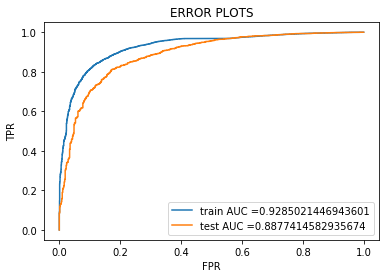

Train confusion matrix
[[ 2196   280]
 [ 2282 11242]]
Test confusion matrix
[[ 510  110]
 [ 630 2750]]


In [87]:
train_fpr_bow_rbf, train_tpr_bow_rbf, thresholds_bow_rbf = roc_curve(y_train, bow_model_rbf.predict_proba(x_train_bigram_counts_rbf)[:,1])
test_fpr_bow_rbf, test_tpr_bow_rbf, thresholds_bow_rbf = roc_curve(y_test, bow_model_rbf.predict_proba(x_test_bigram_counts_rbf)[:,1])

plt.plot(train_fpr_bow_rbf, train_tpr_bow_rbf, label="train AUC ="+str(auc(train_fpr_bow_rbf, train_tpr_bow_rbf)))
plt.plot(test_fpr_bow_rbf, test_tpr_bow_rbf, label="test AUC ="+str(auc(test_fpr_bow_rbf, test_tpr_bow_rbf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bow_model_rbf.predict(x_train_bigram_counts_rbf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bow_model_rbf.predict(x_test_bigram_counts_rbf)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

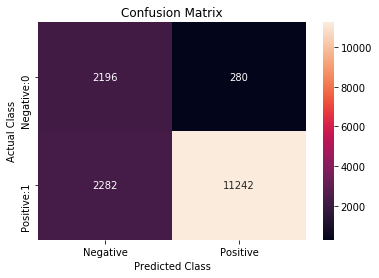

In [88]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_bow_rbf = confusion_matrix(y_train, bow_model_rbf.predict(x_train_bigram_counts_rbf))

df_cm=pd.DataFrame(confusion_matrix_train_bow_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

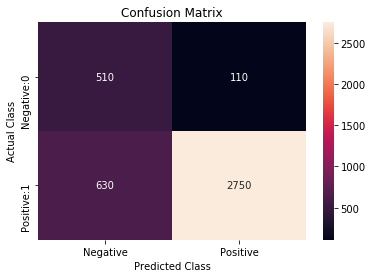

In [89]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_bow_rbf = confusion_matrix(y_test, bow_model_rbf.predict(x_test_bigram_counts_rbf))

df_cm=pd.DataFrame(confusion_matrix_test_bow_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [90]:
# Please write all the code with proper documentation

tfidf_rbf = SVC(kernel = 'rbf' ,class_weight = 'balanced' ,probability= True)

tfidf_rbf_model = GridSearchCV(tfidf_rbf , param_grid = parameters ,cv = 5 ,scoring = 'roc_auc',n_jobs = -1)

tfidf_rbf_model.fit(x_train_tf_idf_rbf ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [91]:
print("best C(hyperparameter) is :" ,tfidf_rbf_model.best_estimator_.C)

best_c = tfidf_rbf_model.best_estimator_.C

best C(hyperparameter) is : 38


In [92]:
tfidf_model_rbf = SVC(kernel = 'rbf' ,C = best_c , class_weight = 'balanced', probability = True)

tfidf_model_rbf.fit(x_train_tf_idf_rbf,y_train)

SVC(C=38, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

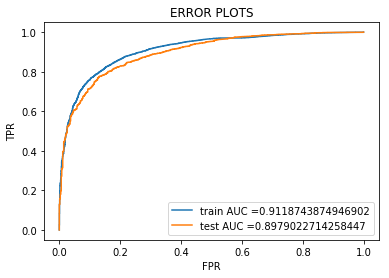

Train confusion matrix
[[ 2132   344]
 [ 2620 10904]]
Test confusion matrix
[[ 523   97]
 [ 698 2682]]


In [93]:
train_fpr_tfidf_rbf, train_tpr_tfidf_rbf, thresholds_tfidf_rbf = roc_curve(y_train, tfidf_model_rbf.predict_proba(x_train_tf_idf_rbf)[:,1])
test_fpr_tfidf_rbf, test_tpr_tfidf_rbf, thresholds_tfidf_rbf = roc_curve(y_test, tfidf_model_rbf.predict_proba(x_test_tf_idf_rbf)[:,1])

plt.plot(train_fpr_tfidf_rbf, train_tpr_tfidf_rbf, label="train AUC ="+str(auc(train_fpr_tfidf_rbf, train_tpr_tfidf_rbf)))
plt.plot(test_fpr_tfidf_rbf, test_tpr_tfidf_rbf, label="test AUC ="+str(auc(test_fpr_tfidf_rbf, test_tpr_tfidf_rbf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, tfidf_model_rbf.predict(x_train_tf_idf_rbf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, tfidf_model_rbf.predict(x_test_tf_idf_rbf)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

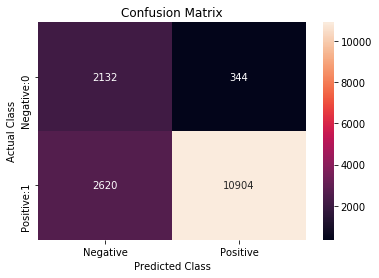

In [94]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_tfidf_rbf = confusion_matrix(y_train, tfidf_model_rbf.predict(x_train_tf_idf_rbf))

df_cm=pd.DataFrame(confusion_matrix_train_tfidf_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

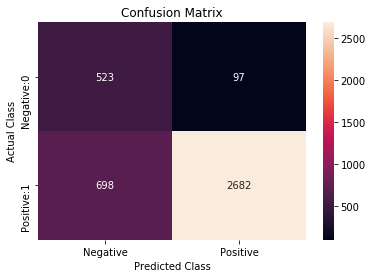

In [95]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_tfidf_rbf = confusion_matrix(y_test, tfidf_model_rbf.predict(x_test_tf_idf_rbf))

df_cm=pd.DataFrame(confusion_matrix_test_tfidf_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [96]:
# Please write all the code with proper documentation
avgw2v_rbf = SVC(kernel = 'rbf' ,class_weight = 'balanced')

avgw2v_rbf_model = GridSearchCV(avgw2v_rbf , param_grid = parameters ,cv = 5 ,scoring = 'roc_auc',n_jobs = -1)

avgw2v_rbf_model.fit(sent_vectors_train_rbf ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [104]:
print("best C(hyperparameter) is :" ,avgw2v_rbf_model.best_estimator_.C)

best_c = avgw2v_rbf_model.best_estimator_.C

best C(hyperparameter) is : 6


In [105]:
avgw2v_model_rbf = SVC(kernel = 'rbf' ,C = best_c , class_weight = 'balanced', probability = True)

avgw2v_model_rbf.fit(sent_vectors_train_rbf,y_train)

SVC(C=6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

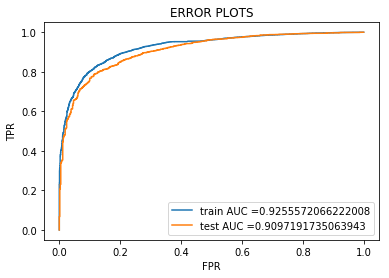

Train confusion matrix
[[ 2196   280]
 [ 2495 11029]]
Test confusion matrix
[[ 521   99]
 [ 624 2756]]


In [106]:
train_fpr_avgw2v_rbf, train_tpr_avgw2v_rbf, thresholds_avgw2v_rbf = roc_curve(y_train, avgw2v_model_rbf.predict_proba(sent_vectors_train_rbf)[:,1])
test_fpr_avgw2v_rbf, test_tpr_avgw2v_rbf, thresholds_avgw2v_rbf = roc_curve(y_test, avgw2v_model_rbf.predict_proba(sent_vectors_test_rbf)[:,1])

plt.plot(train_fpr_avgw2v_rbf, train_tpr_avgw2v_rbf, label="train AUC ="+str(auc(train_fpr_avgw2v_rbf, train_tpr_avgw2v_rbf)))
plt.plot(test_fpr_avgw2v_rbf, test_tpr_avgw2v_rbf, label="test AUC ="+str(auc(test_fpr_avgw2v_rbf, test_tpr_avgw2v_rbf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, avgw2v_model_rbf.predict(sent_vectors_train_rbf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, avgw2v_model_rbf.predict(sent_vectors_test_rbf)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

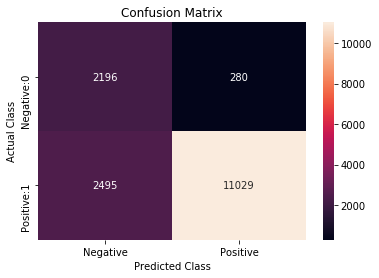

In [107]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_avgw2v_rbf = confusion_matrix(y_train, avgw2v_model_rbf.predict(sent_vectors_train_rbf))

df_cm=pd.DataFrame(confusion_matrix_train_avgw2v_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

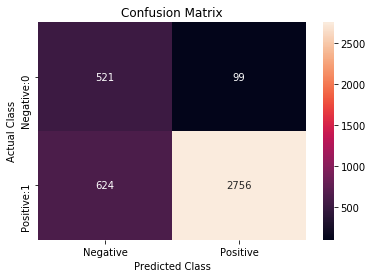

In [108]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_avgw2v_rbf = confusion_matrix(y_test, avgw2v_model_rbf.predict(sent_vectors_test_rbf))

df_cm=pd.DataFrame(confusion_matrix_test_avgw2v_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [109]:
# Please write all the code with proper documentation


# Please write all the code with proper documentation
tfidfavgw2v_rbf = SVC(kernel = 'rbf' ,class_weight = 'balanced')

tfidfavgw2v_rbf_model = GridSearchCV(tfidfavgw2v_rbf , param_grid = parameters ,cv = 5 ,scoring = 'roc_auc',n_jobs = -1)

tfidfavgw2v_rbf_model.fit(w2v_tfidf_sent_vectors_train_rbf ,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [110]:
print("best C(hyperparameter) is :" ,tfidfavgw2v_rbf_model.best_estimator_.C)

best_c = tfidfavgw2v_rbf_model.best_estimator_.C

best C(hyperparameter) is : 2


In [111]:
tfidfavgw2v_model_rbf = SVC(kernel = 'rbf' ,C = best_c , class_weight = 'balanced', probability = True)

tfidfavgw2v_model_rbf.fit(w2v_tfidf_sent_vectors_train_rbf,y_train)

SVC(C=2, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

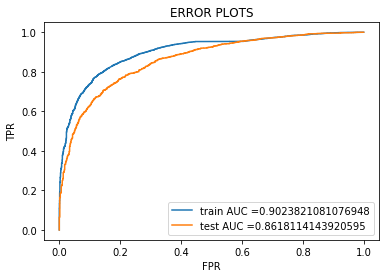

Train confusion matrix
[[ 2159   317]
 [ 2902 10622]]
Test confusion matrix
[[ 493  127]
 [ 788 2592]]


In [112]:
train_fpr_tfidfavgw2v_rbf, train_tpr_tfidfavgw2v_rbf, thresholds_tfidfavgw2v_rbf = roc_curve(y_train, tfidfavgw2v_model_rbf.predict_proba(w2v_tfidf_sent_vectors_train_rbf)[:,1])
test_fpr_tfidfavgw2v_rbf, test_tpr_tfidfavgw2v_rbf, thresholds_tfidfavgw2v_rbf = roc_curve(y_test, tfidfavgw2v_model_rbf.predict_proba(w2v_tfidf_sent_vectors_test_rbf)[:,1])

plt.plot(train_fpr_tfidfavgw2v_rbf, train_tpr_tfidfavgw2v_rbf, label="train AUC ="+str(auc(train_fpr_tfidfavgw2v_rbf, train_tpr_tfidfavgw2v_rbf)))
plt.plot(test_fpr_tfidfavgw2v_rbf, test_tpr_tfidfavgw2v_rbf, label="test AUC ="+str(auc(test_fpr_tfidfavgw2v_rbf, test_tpr_tfidfavgw2v_rbf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, tfidfavgw2v_model_rbf.predict(w2v_tfidf_sent_vectors_train_rbf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, tfidfavgw2v_model_rbf.predict(w2v_tfidf_sent_vectors_test_rbf)))

Heatmap of train confusion matrix


Text(33.0, 0.5, 'Actual Class')

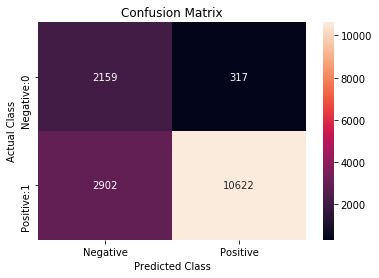

In [113]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_tfidfavgw2v_rbf = confusion_matrix(y_train, tfidfavgw2v_model_rbf.predict(w2v_tfidf_sent_vectors_train_rbf))

df_cm=pd.DataFrame(confusion_matrix_train_tfidfavgw2v_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33.0, 0.5, 'Actual Class')

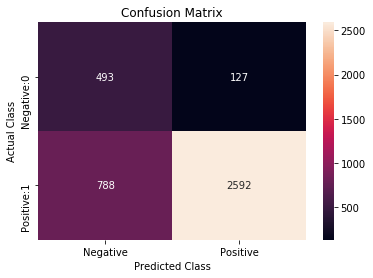

In [114]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_tfidfavgw2v_rbf = confusion_matrix(y_test, tfidfavgw2v_model_rbf.predict(w2v_tfidf_sent_vectors_test_rbf))

df_cm=pd.DataFrame(confusion_matrix_test_tfidfavgw2v_rbf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

# [6] Conclusions

In [86]:
from prettytable import PrettyTable
X = PrettyTable()
print("Comparison table for Linear SVM using SGD classifier")

X.field_names=["Model_Name","Train_Accuracy","Test_Accuracy","Optimal alpha"]
X.add_row(["SGD classifier with hinge loss on BOW", 98.4, 95.4, 0.001])
X.add_row(["SGD classifier with hinge loss on TFIDF", 98.0, 95.9, 0.0001])
X.add_row(["SGD classifier with hinge loss on AVG W2V", 90.8, 90.5,0.01])
X.add_row(["SGD classifier with hinge loss on TFIDF-AvgW2V", 88.4,88,0.01])
print(X)
print("\n")
print("="*100)
print("\n")
print("Comparison table for RBF SVM")
Y = PrettyTable()
Y.field_names=["Model_Name","Train_Accuracy","Test_Accuracy","Optimal C"]
Y.add_row(["RBF SVM on BOW", 92.8, 88.7, 6])
Y.add_row(["RBF SVM on TFIDF", 91.1, 89.7, 38])
Y.add_row(["RBF SVM on AVG W2V", 92.5, 90.9,6])
Y.add_row(["RBF SVM on TFIDF-AvgW2V", 90.2,86.1,2])
print(Y)

Comparison table for Linear SVM using SGD classifier
+------------------------------------------------+----------------+---------------+---------------+
|                   Model_Name                   | Train_Accuracy | Test_Accuracy | Optimal alpha |
+------------------------------------------------+----------------+---------------+---------------+
|     SGD classifier with hinge loss on BOW      |      98.4      |      95.4     |     0.001     |
|    SGD classifier with hinge loss on TFIDF     |      98.0      |      95.9     |     0.0001    |
|   SGD classifier with hinge loss on AVG W2V    |      90.8      |      90.5     |      0.01     |
| SGD classifier with hinge loss on TFIDF-AvgW2V |      88.4      |       88      |      0.01     |
+------------------------------------------------+----------------+---------------+---------------+




Comparison table for RBF SVM
+-------------------------+----------------+---------------+-----------+
|        Model_Name       | Train_Accurac